In [1]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping

from keras.utils import plot_model
from keras import optimizers, activations, regularizers, losses
from keras import backend as K
from keras.backend import sigmoid
from sklearn.model_selection import train_test_split, KFold
from keras.utils.generic_utils import get_custom_objects
#from sklearn.datasets import make_regression
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import json

Using TensorFlow backend.


## ROM Data Processing and Splitting

In [19]:
'''Import data'''

# File path
data = h5py.File('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/JB2008_1999_2010_ROM_r100.mat', 'r')
#data = scipy.io.loadmat('/Users/maggiezhang/Desktop/NRLMSISE_1997_2008_ROM_r100.mat')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data)

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()

pred_number = 24

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
# Training input

# Testing the 70, 15, 15 for train, val, test 

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
print(sw_data_train.shape, sw_data_train_append.shape)
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
print(x_train.shape)
# TODO: we could also add the SW data of the next time step if that perform better

# Training output
# Output is reduced-order density data at next time step
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
print(dens_data.shape)
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
print(sw_data_test.shape)
print(dens_data_test.shape)
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)
print(x_test.shape)
print(x_test[0])

# Test output
# Output is reduced-order density data at next time step
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
print(y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

(87869, 14) (87869, 14)
(87869, 38)
(103404, 10)
(15510, 28)
(15510, 10)
(15510, 38)
[ 9.32409674e+01  2.44422754e-01  7.93390299e-01  2.58319429e+00
 -3.51546884e-02  2.43685380e-01 -1.58177648e-01  6.33623427e-01
 -3.39279403e-01  3.59103680e-02  8.30000000e+01  1.60000000e+01
  6.80000000e+01  6.96000000e+01  4.75000000e+01  4.73000000e+01
  6.38000000e+01  6.38000000e+01  5.64000000e+01  5.70000000e+01
  5.05000000e+01  1.08660558e+00  6.43918064e-02  2.78875685e-02
  8.30000000e+01  1.70000000e+01  6.80000000e+01  6.96000000e+01
  4.75000000e+01  4.73000000e+01  6.38000000e+01  6.38000000e+01
  5.64000000e+01  5.70000000e+01  5.05000000e+01  1.34912175e+00
  6.50538483e-02  2.81737803e-02]
(15510, 10)


In [17]:
with open('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/recurrent_model.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/recurrent_model.h5')
model_NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               4680      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [71]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [73]:
xdata= np.load("NRLMSISE_concat_data.npy")
xdata_1 = np.log10(xdata)
xmat = (xdata_1 - np.mean(xdata_1, keepdims=True)) / np.std(xdata_1, keepdims=True)
xmat = np.reshape(xmat, (105192, 24, 20, 36, 1))

full_sw = scipy.io.loadmat("/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/SWdata_NRLMSISE_1997_2008_smooth.mat")
full_sw = full_sw['SWdataFullSmooth']

In [76]:
'''CNN to NN 45'''
with open('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/Models/1x1final12.json','r') as f:
    model_encoder_json = json.load(f)
    model_encoder_json = json.dumps(model_encoder_json)
    model_encoder_json = str(model_encoder_json)

model_encoder = model_from_json(model_encoder_json)
#weights =h5py.File('/Users/maggiezhang/Desktop/1x1filter120.h5', 'r')
model_encoder.load_weights('/Users/maggiezhang/Desktop/1x1filter120.h5')
model_encoder.summary()

encoder_model_cnn = Model(inputs=model_encoder.input, outputs=model_encoder.layers[8].output)
encoder_model_cnn.summary()

decode_input = Input(model_encoder.layers[9].input_shape[1:])
decoder_model_cnn = decode_input
for layer in model_encoder.layers[9:]:
    decoder_model_cnn = layer(decoder_model_cnn)
decoder_model_cnn = Model(inputs=decode_input, outputs=decoder_model_cnn)

decoder_model_cnn.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 795)    29415     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 795)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 204)     3243804   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 204)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 934)      4573798   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 934)      4   

In [77]:
rom_predict = encoder_model_cnn.predict(xmat)

In [79]:
print(rom_predict.shape)
print(full_sw.shape)

split_15 = int(rom_predict.shape[0]*0.85)

(105192, 10)
(105192, 11)


In [16]:
dens_data_train = rom_predict[0:split_15-pred_number,:]
sw_data_train = full_sw[0:split_15-pred_number,:]
sw_data_train_append = full_sw[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
# TODO: we could also add the SW data of the next time step if that perform better

# Training output
# Output is reduced-order density data at next time step
y_train = rom_predict[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = rom_predict[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = full_sw[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = full_sw[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
# Output is reduced-order density data at next time step
y_test = rom_predict[split_15-pred_number:-pred_number-1,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

NameError: name 'rom_predict' is not defined

In [83]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73614, 32)
(73614, 10)
(15778, 32)
(15778, 10)


## Original Model with 3 Leaky layers of 0.3

In [84]:
'''Create NN'''
def swish(x, beta=1.0):
    return x * K.sigmoid(beta * x)

def leaky_relu6(x):
    return K.relu(x, alpha = 0.3)

model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
#kernel_regularizer=regularizers.l2(0.01)
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('tanh'))
model.add(Dense(40, kernel_initializer='random_uniform'))
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('sigmoid'))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))


Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 31us/step - loss: 17.3782 - accuracy: 0.8850 - val_loss: 1.0231 - val_accuracy: 0.9389
Epoch 2/500
73614/73614 [==============================] - 3s 40us/step - loss: 0.7232 - accuracy: 0.9469 - val_loss: 0.2401 - val_accuracy: 0.9746
Epoch 3/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1984 - accuracy: 0.9748 - val_loss: 0.1780 - val_accuracy: 0.9764
Epoch 4/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.1506 - accuracy: 0.9775 - val_loss: 0.1217 - val_accuracy: 0.9805
Epoch 5/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1209 - accuracy: 0.9807 - val_loss: 0.1125 - val_accuracy: 0.9811
Epoch 6/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1027 - accuracy: 0.9824 - val_loss: 0.0949 - val_accuracy: 0.9834
Epoch 7/500
73614/73614 [==============================] - 2s

Epoch 56/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0137 - val_accuracy: 0.9953
Epoch 57/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0176 - accuracy: 0.9939 - val_loss: 0.0136 - val_accuracy: 0.9959
Epoch 58/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0217 - val_accuracy: 0.9953
Epoch 59/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.0196 - val_accuracy: 0.9947
Epoch 60/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.0110 - val_accuracy: 0.9954
Epoch 61/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.0140 - val_accuracy: 0.9958
Epoch 62/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0162 - accuracy: 0.9946

Epoch 111/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0110 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9966
Epoch 112/500
73614/73614 [==============================] - 2s 34us/step - loss: 0.0115 - accuracy: 0.9953 - val_loss: 0.0072 - val_accuracy: 0.9965
Epoch 113/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0111 - accuracy: 0.9953 - val_loss: 0.0083 - val_accuracy: 0.9964
Epoch 114/500
73614/73614 [==============================] - 3s 36us/step - loss: 0.0115 - accuracy: 0.9952 - val_loss: 0.0108 - val_accuracy: 0.9963
Epoch 115/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0113 - accuracy: 0.9953 - val_loss: 0.0073 - val_accuracy: 0.9974
Epoch 116/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0110 - accuracy: 0.9956 - val_loss: 0.0228 - val_accuracy: 0.9926
Epoch 117/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0113 - accuracy:

Epoch 220/500
73614/73614 [==============================] - 3s 36us/step - loss: 0.0072 - accuracy: 0.9963 - val_loss: 0.0152 - val_accuracy: 0.9919
Epoch 221/500
73614/73614 [==============================] - 3s 43us/step - loss: 0.0072 - accuracy: 0.9960 - val_loss: 0.0069 - val_accuracy: 0.9964
Epoch 222/500
73614/73614 [==============================] - 3s 41us/step - loss: 0.0072 - accuracy: 0.9966 - val_loss: 0.0049 - val_accuracy: 0.9961
Epoch 223/500
73614/73614 [==============================] - 3s 41us/step - loss: 0.0071 - accuracy: 0.9964 - val_loss: 0.0103 - val_accuracy: 0.9960
Epoch 224/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0075 - accuracy: 0.9965 - val_loss: 0.0048 - val_accuracy: 0.9971
Epoch 225/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0067 - accuracy: 0.9970 - val_loss: 0.0104 - val_accuracy: 0.9952
Epoch 226/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0074 - accuracy:

Epoch 329/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0052 - accuracy: 0.9971 - val_loss: 0.0044 - val_accuracy: 0.9966
Epoch 330/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy: 0.9970
Epoch 331/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0057 - accuracy: 0.9970 - val_loss: 0.0060 - val_accuracy: 0.9970
Epoch 332/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0058 - accuracy: 0.9968 - val_loss: 0.0044 - val_accuracy: 0.9975
Epoch 333/500
73614/73614 [==============================] - 3s 43us/step - loss: 0.0055 - accuracy: 0.9972 - val_loss: 0.0046 - val_accuracy: 0.9977
Epoch 334/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0056 - accuracy: 0.9969 - val_loss: 0.0078 - val_accuracy: 0.9959
Epoch 335/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0054 - accuracy:

Epoch 438/500
73614/73614 [==============================] - 4s 50us/step - loss: 0.0046 - accuracy: 0.9972 - val_loss: 0.0027 - val_accuracy: 0.9980
Epoch 439/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9980
Epoch 440/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0046 - accuracy: 0.9971 - val_loss: 0.0106 - val_accuracy: 0.9958
Epoch 441/500
73614/73614 [==============================] - 4s 49us/step - loss: 0.0048 - accuracy: 0.9972 - val_loss: 0.0093 - val_accuracy: 0.9966
Epoch 442/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0046 - accuracy: 0.9971 - val_loss: 0.0042 - val_accuracy: 0.9974
Epoch 443/500
73614/73614 [==============================] - 3s 46us/step - loss: 0.0047 - accuracy: 0.9972 - val_loss: 0.0085 - val_accuracy: 0.9953
Epoch 444/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0045 - accuracy:

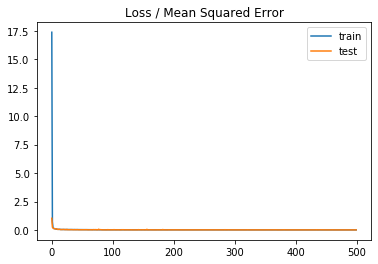

In [85]:
'''Train NN'''
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#early_stop = EarlyStopping(patience=5)
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647, random_state=42)
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 1000, batch_size = 32) #, callbacks=[early_stop])
#validation_data=(x_test, y_test)
#validation_split=0.25
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


## Test NN with leaky relu "#" to cap max value

In [64]:
test_model = Sequential()
#test_model.add(Dense(120, kernel_initializer='random_uniform'))
#model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(80, kernel_initializer='random_uniform'))
#test_model.add(Activation(lambda x: activations.relu(x, max_value = 6, alpha=0.2)))
#test_model.add(PReLU())
test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(40, kernel_initializer='random_uniform'))
#test_model.add(Activation(lambda x: activations.relu(x, max_value = 100, alpha=0.2)))
#test_model.add(PReLU())
test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(20, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 10, alpha=0.3)))
#test_model.add(PReLU())
#test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(10, kernel_initializer='random_uniform'))

In [65]:
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
test_model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647)

history = test_model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32) 

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 28us/step - loss: 19.5427 - accuracy: 0.7803 - val_loss: 8.8121 - val_accuracy: 0.7945
Epoch 2/500
73614/73614 [==============================] - 2s 26us/step - loss: 3.8040 - accuracy: 0.9104 - val_loss: 1.7634 - val_accuracy: 0.9559
Epoch 3/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.4327 - accuracy: 0.9669 - val_loss: 1.0587 - val_accuracy: 0.9816
Epoch 4/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.9149 - accuracy: 0.9841 - val_loss: 0.8290 - val_accuracy: 0.9869
Epoch 5/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.7907 - accuracy: 0.9859 - val_loss: 0.7071 - val_accuracy: 0.9872
Epoch 6/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.6188 - accuracy: 0.9870 - val_loss: 0.5399 - val_accuracy: 0.9833
Epoch 7/500
73614/73614 [==============================] - 2s

Epoch 56/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0209 - accuracy: 0.9957 - val_loss: 0.0183 - val_accuracy: 0.9960
Epoch 57/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.0206 - accuracy: 0.9959 - val_loss: 0.0244 - val_accuracy: 0.9950
Epoch 58/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0216 - accuracy: 0.9958 - val_loss: 0.0776 - val_accuracy: 0.9916
Epoch 59/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0209 - accuracy: 0.9959 - val_loss: 0.0484 - val_accuracy: 0.9916
Epoch 60/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0198 - accuracy: 0.9959 - val_loss: 0.0148 - val_accuracy: 0.9952
Epoch 61/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 0.0195 - val_accuracy: 0.9957
Epoch 62/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0194 - accuracy: 0.9956

Epoch 111/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0121 - val_accuracy: 0.9957
Epoch 112/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0137 - val_accuracy: 0.9952
Epoch 113/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0164 - val_accuracy: 0.9955
Epoch 114/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.0152 - val_accuracy: 0.9950
Epoch 115/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0123 - val_accuracy: 0.9961
Epoch 116/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.0108 - val_accuracy: 0.9965
Epoch 117/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0136 - accuracy:

Epoch 220/500
73614/73614 [==============================] - 2s 30us/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0130 - val_accuracy: 0.9962
Epoch 221/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0086 - val_accuracy: 0.9952
Epoch 222/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0069 - val_accuracy: 0.9970
Epoch 223/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0151 - val_accuracy: 0.9964
Epoch 224/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0077 - val_accuracy: 0.9973
Epoch 225/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.0086 - val_accuracy: 0.9973
Epoch 226/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0093 - accuracy:

KeyboardInterrupt: 

## Plot Errors and Save Model to JSON/h5 file

'\nmodel_json = model.to_json()\nwith open("NN_model_NRLMSISE.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("NN_model_NRLMSISE.h5")\nprint("Saved model")\n#'

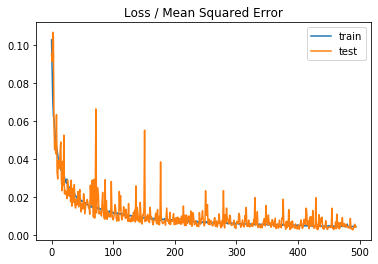

In [87]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'][5:], label='train')
plt.plot(history.history['val_loss'][5:], label='test')
plt.legend()

'''
model_json = model.to_json()
with open("NN_model_NRLMSISE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NN_model_NRLMSISE.h5")
print("Saved model")
#'''

In [18]:
with open('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/LeakyReluCapModel.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN1 = model_from_json(model_NN_json)
model_NN1.load_weights('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/LeakyReluCapModel.h5')
model_NN1.summary()

ValueError: Unknown activation function:<lambda>

## Compare errors over recurrent timesteps for test_model
>for pred_number of hrs

/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[1.24481031e-03 2.84758188e-03 4.79037495e-03 7.86109095e-03
  1.33993416e-02 2.44252727e-02 4.94666124e-02 1.22521788e-01
  4.84437765e-01 4.90074985e+00 9.92836358e+01 2.43140203e+03
  6.21165839e+04 1.60161976e+06 4.13813964e+07 1.06969382e+09
  2.76542986e+10 7.14952479e+11 1.84839238e+13 4.77872179e+14
  1.23546216e+16 3.19409020e+17 8.25780990e+18 2.13492493e+20]]


/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.15110589 0.29674748 0.43562641 0.50361218 0.57132778 0.63888896
  0.68561794 0.73268556 0.77976357 0.8159247  0.85263477 0.88958658
  0.9234498  0.9575136  0.99138967 1.02194094 1.05270738 1.08334678
  1.11425343 1.1451805  1.17598696 1.20621032 1.23604025 1.26551422]]
[1.21388692e+02 1.04210340e+02 9.09378527e+01 6.40639051e+01
 4.26384967e+01 2.61568812e+01 1.38602161e+01 5.98004297e+00
 1.60962589e+00 1.66489766e-01 8.58786816e-03 3.65873916e-04
 1.48663971e-05 5.97840775e-07 2.39573759e-08 9.55358367e-10
 3.80666816e-11 1.51527103e-12 6.02822994e-14 2.39641593e-15
 9.51859957e-17 3.77638152e-18 1.49681363e-19 5.92767553e-21]


/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


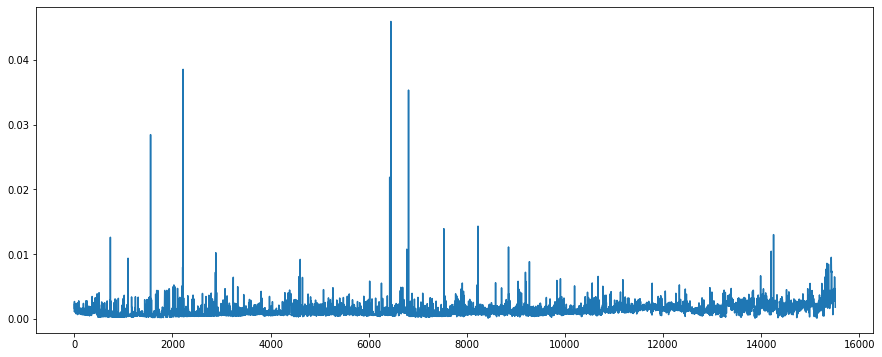

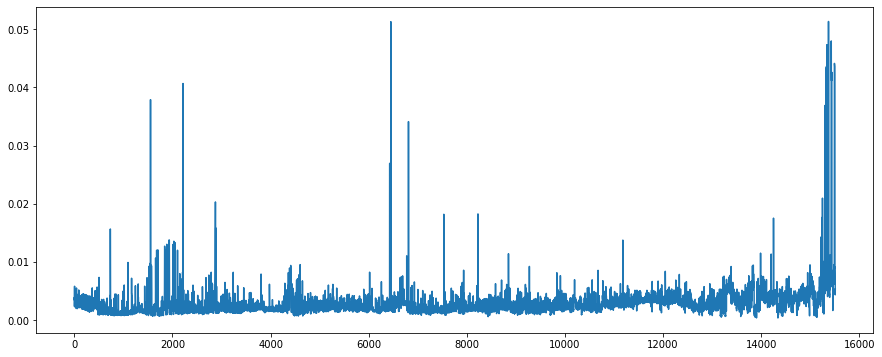

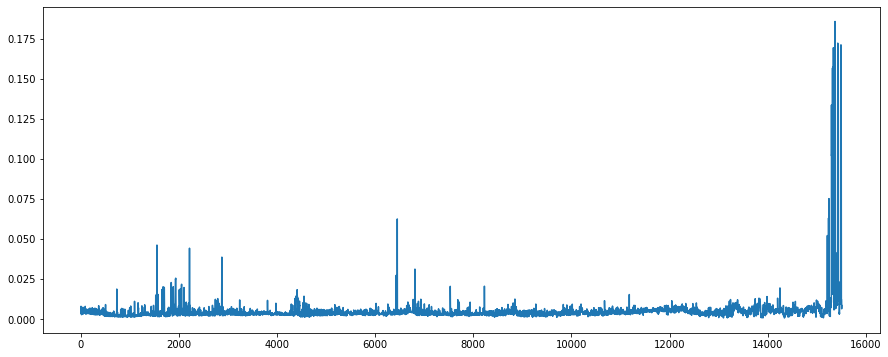

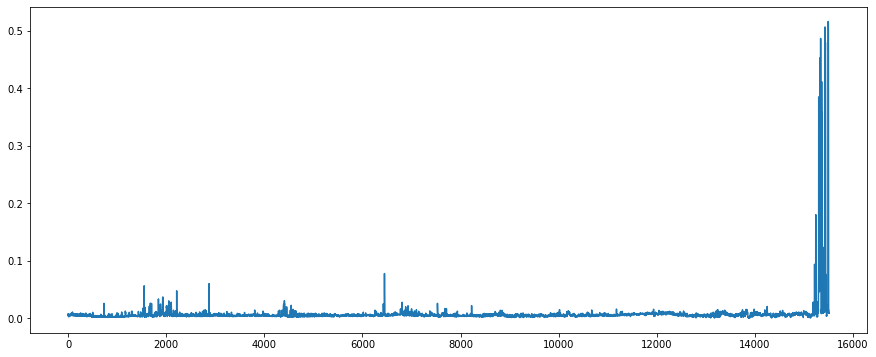

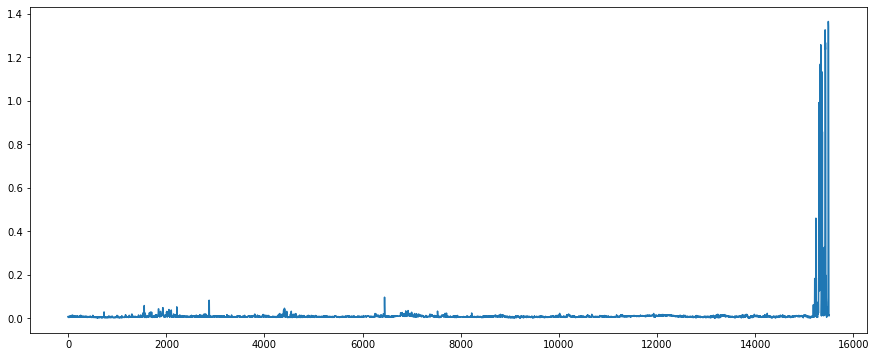

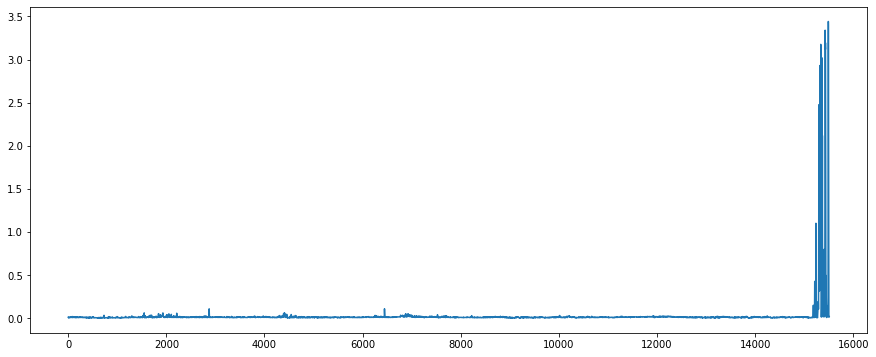

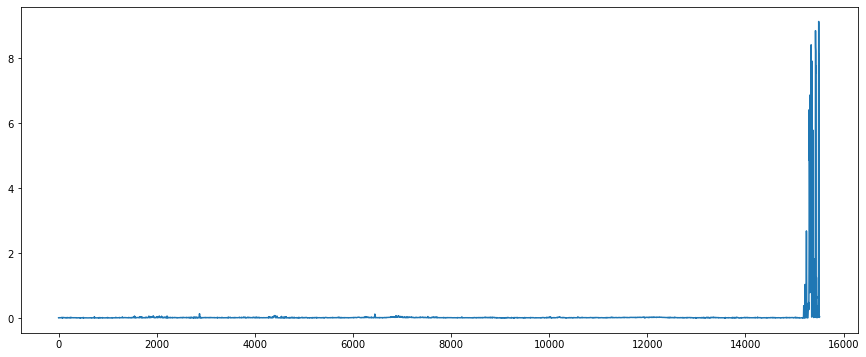

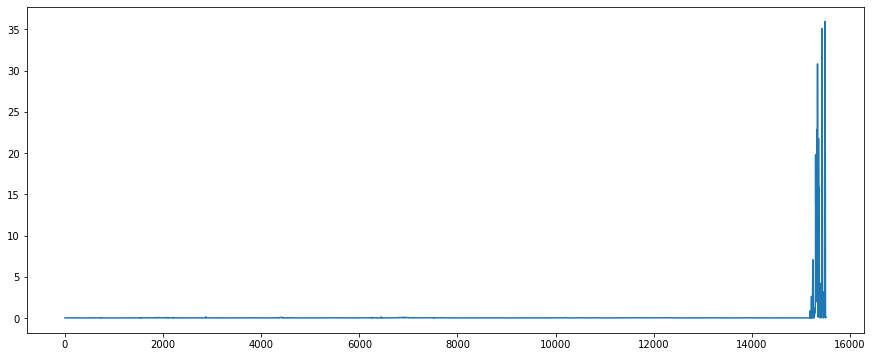

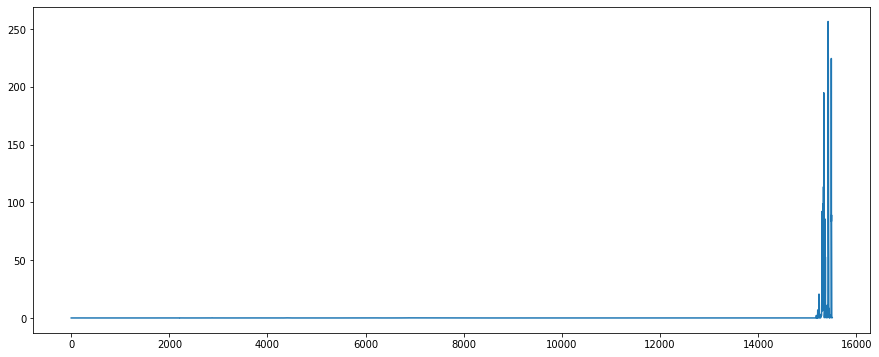

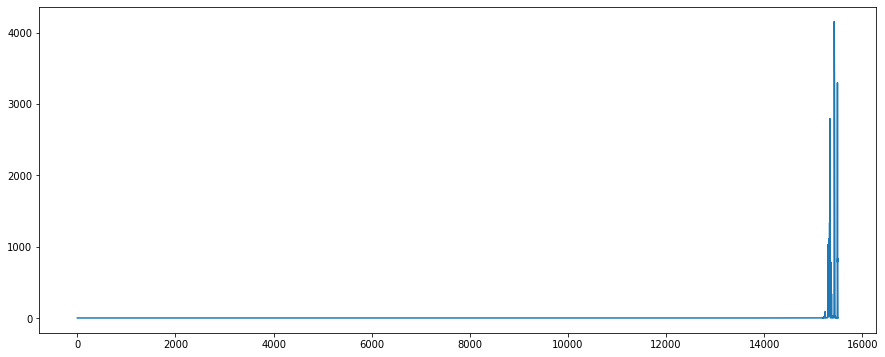

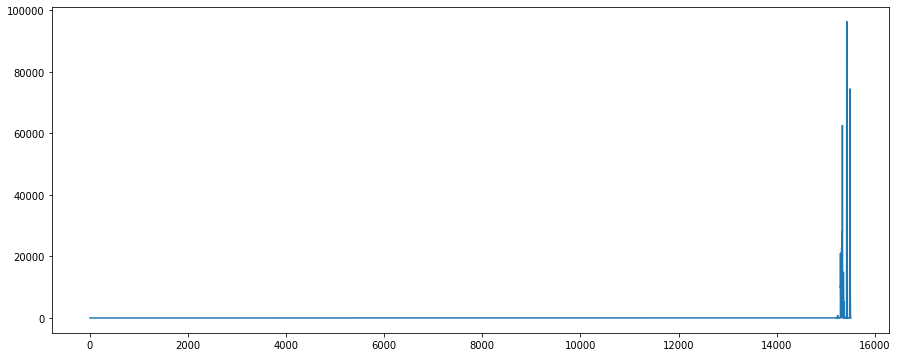

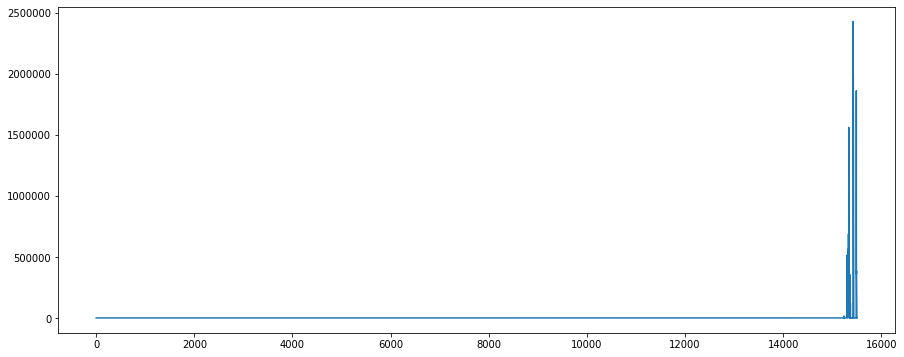

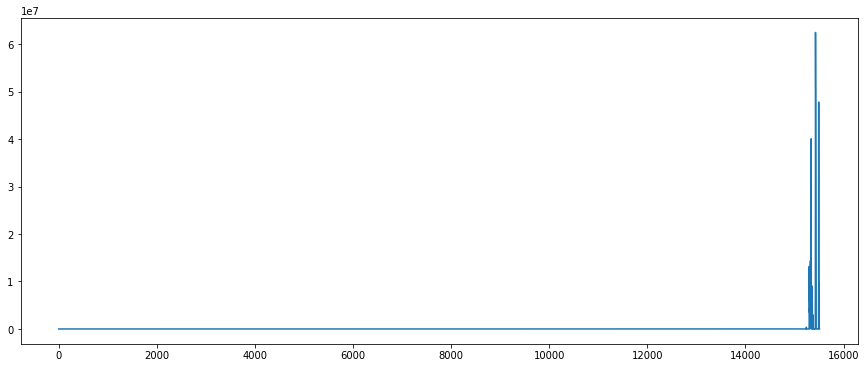

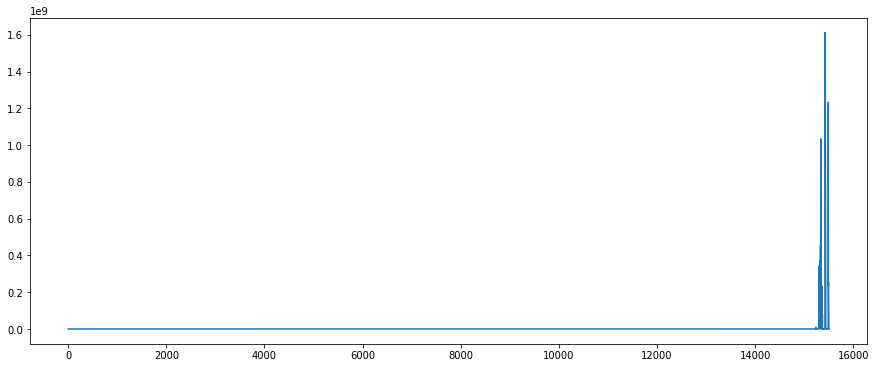

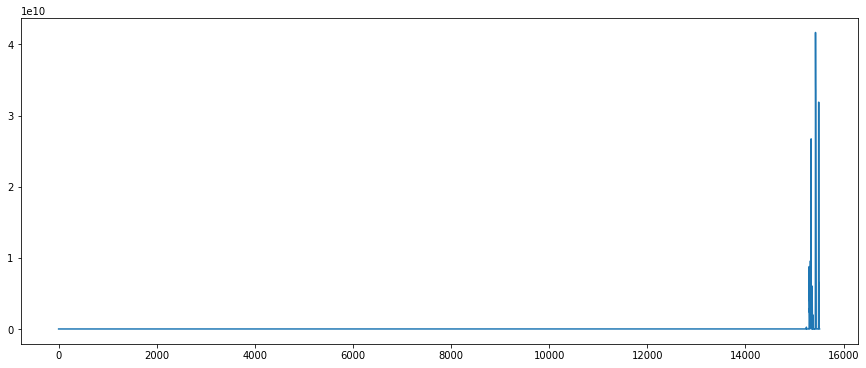

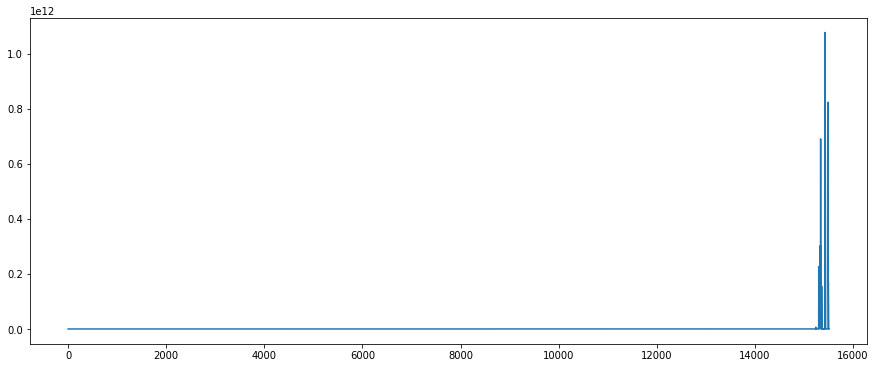

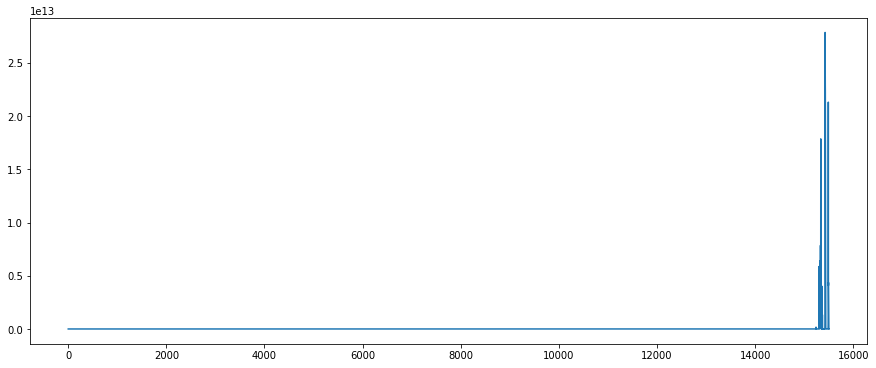

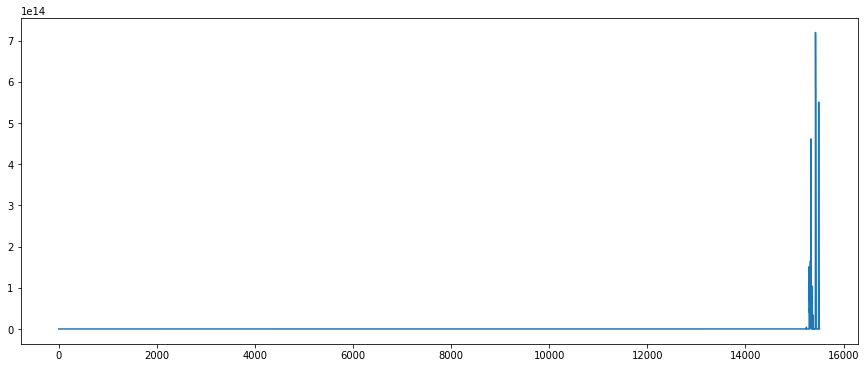

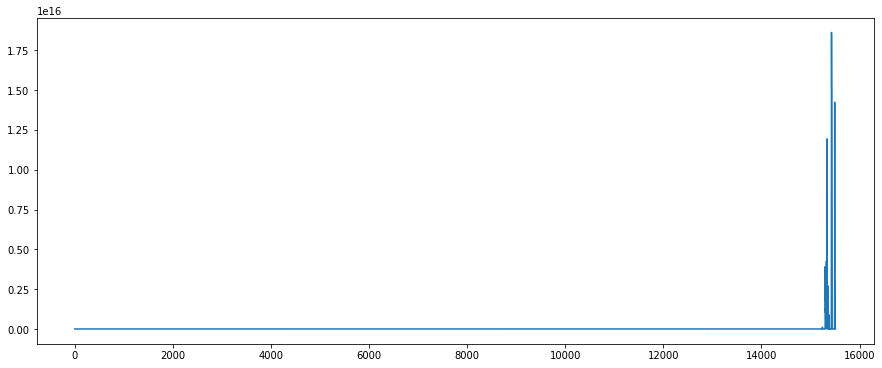

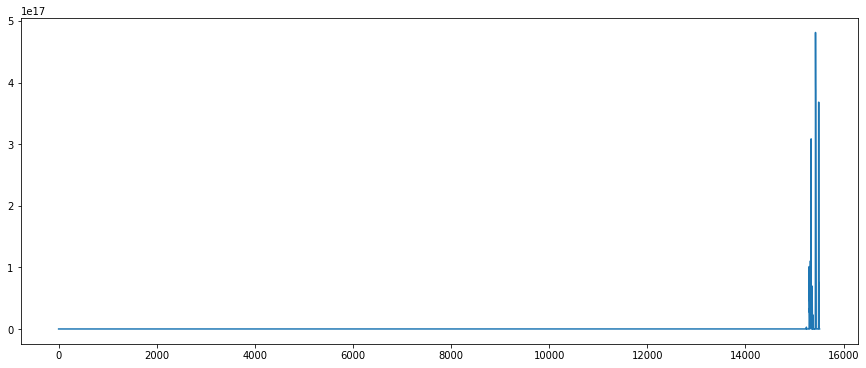

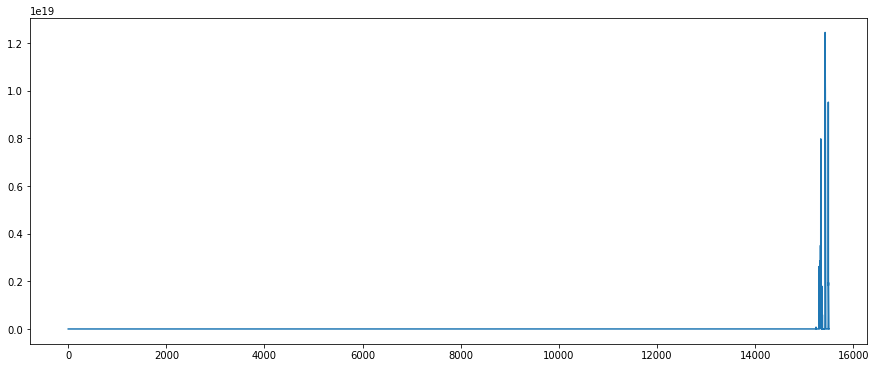

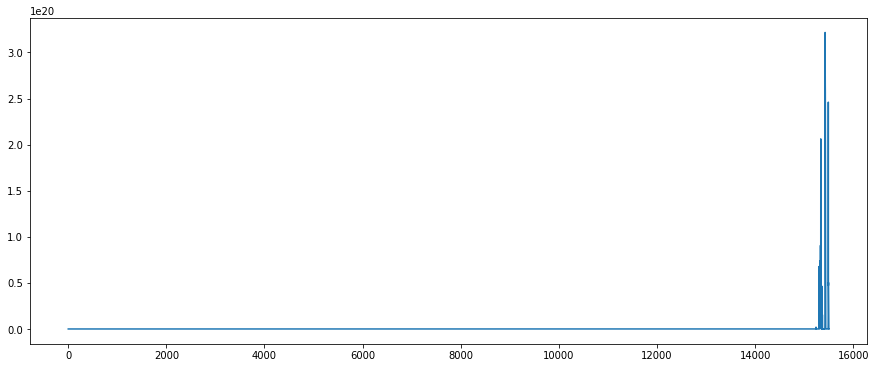

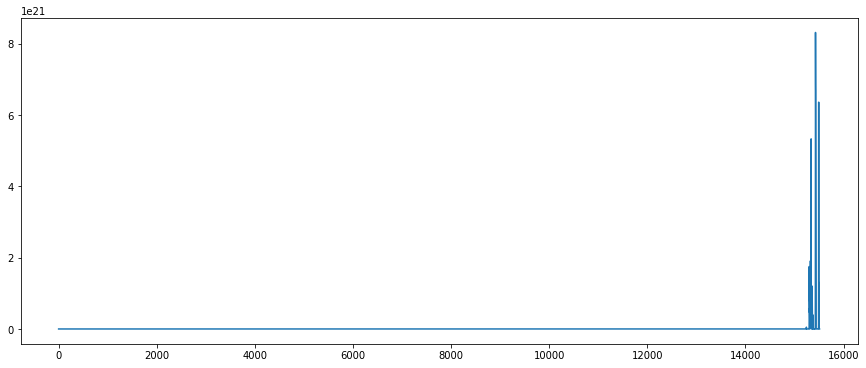

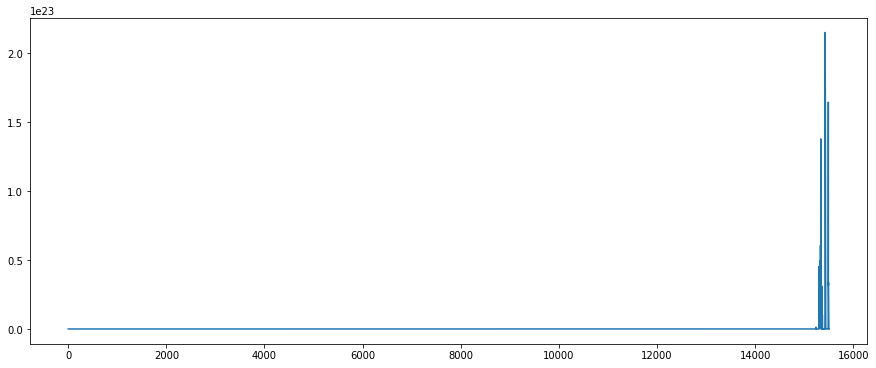

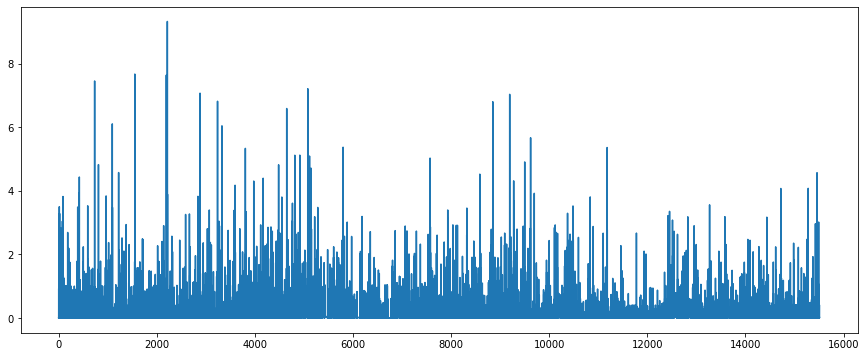

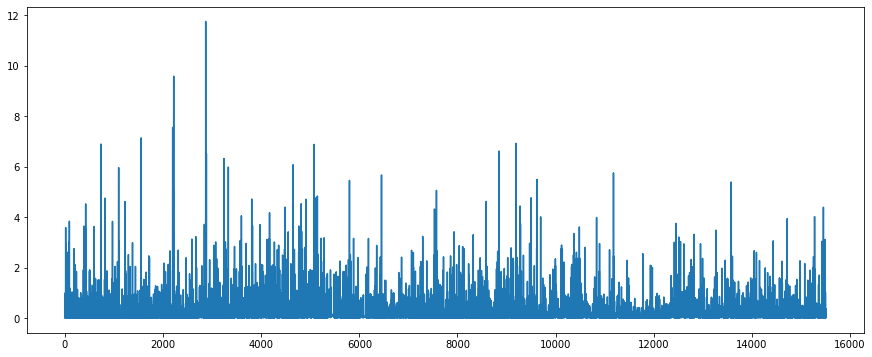

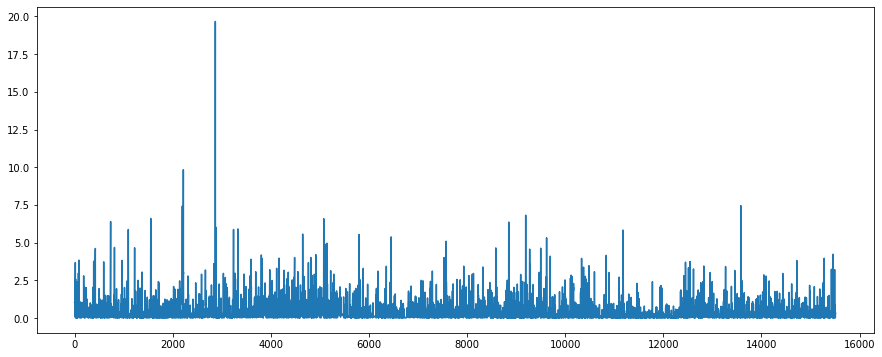

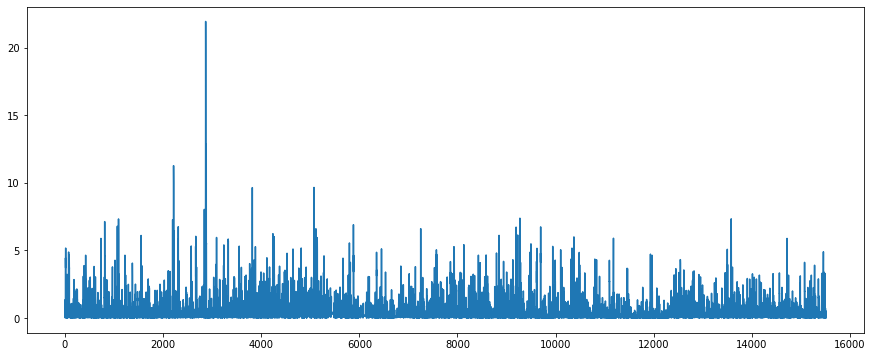

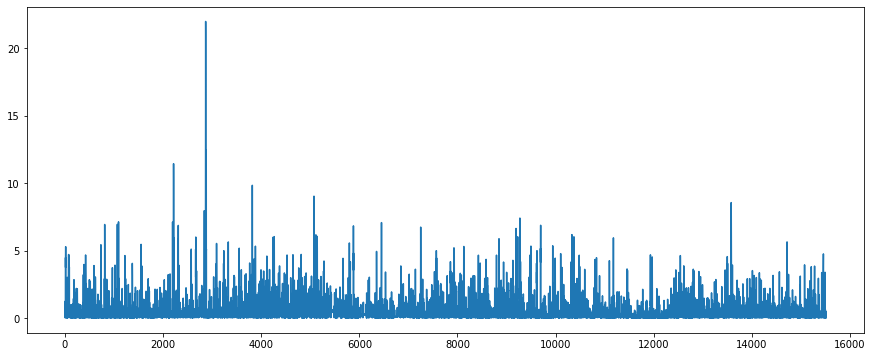

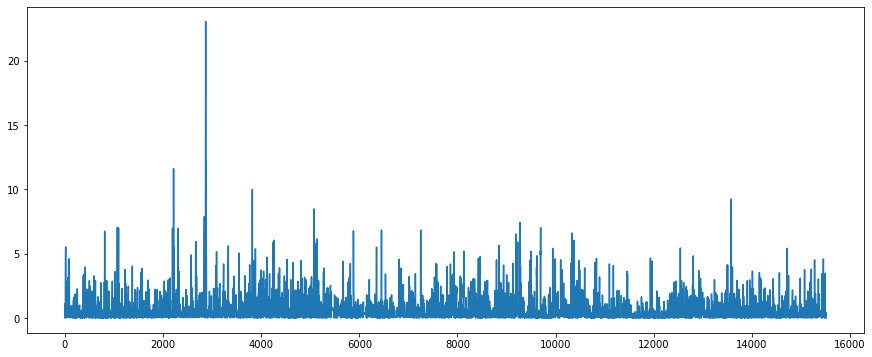

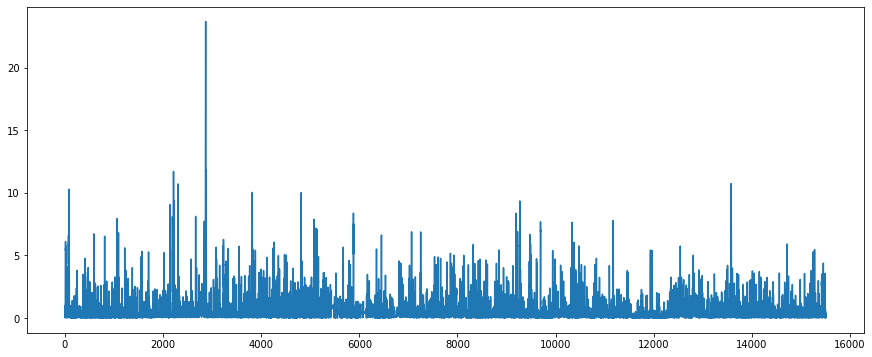

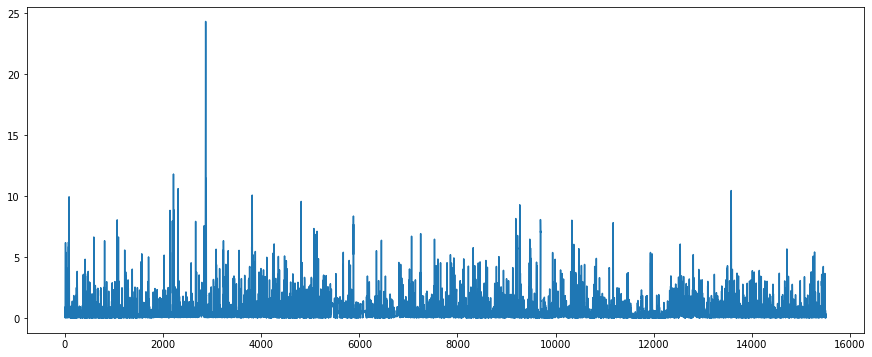

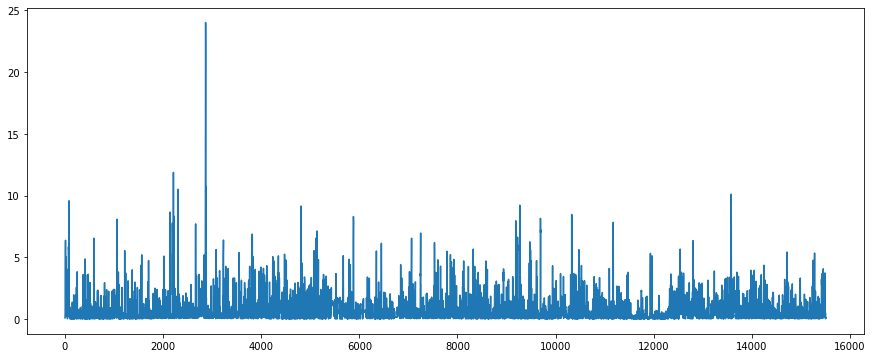

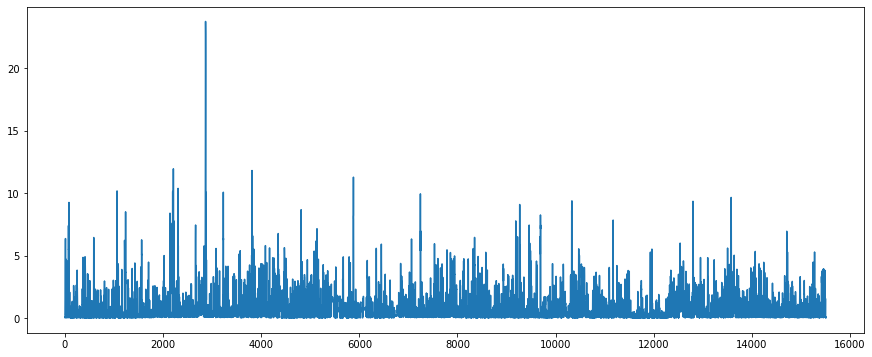

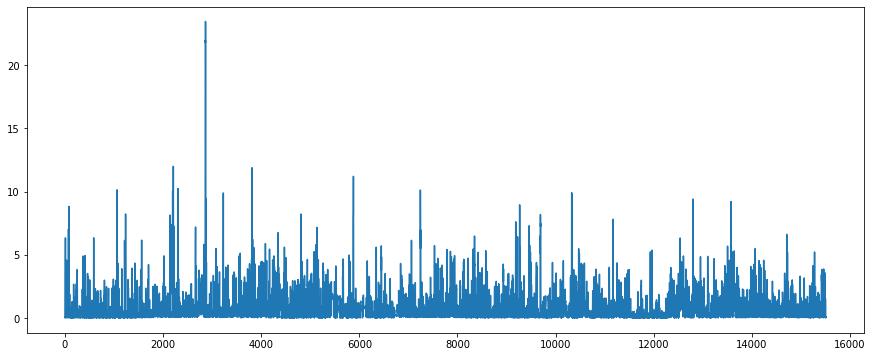

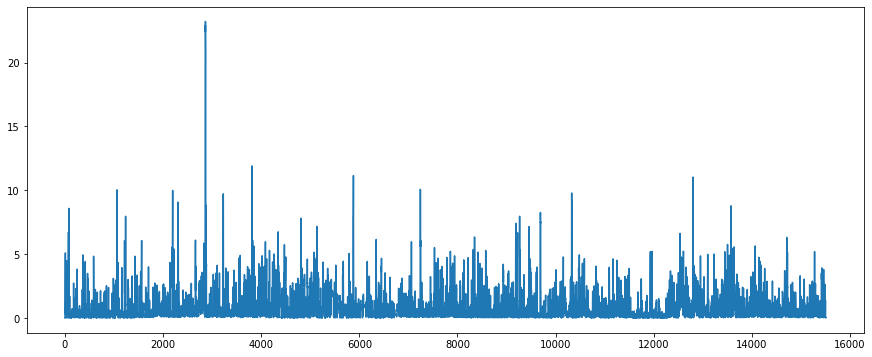

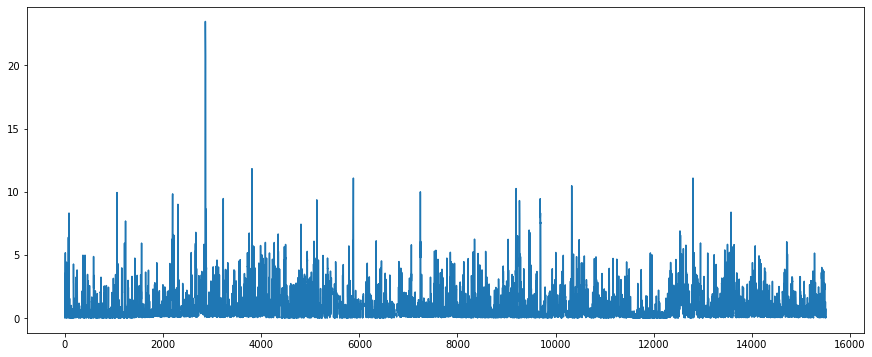

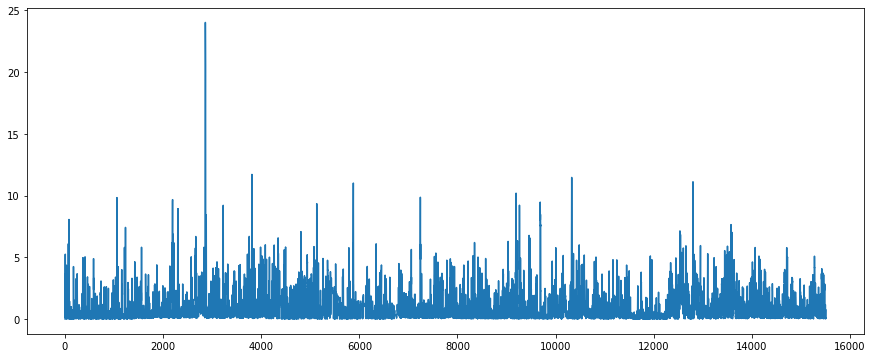

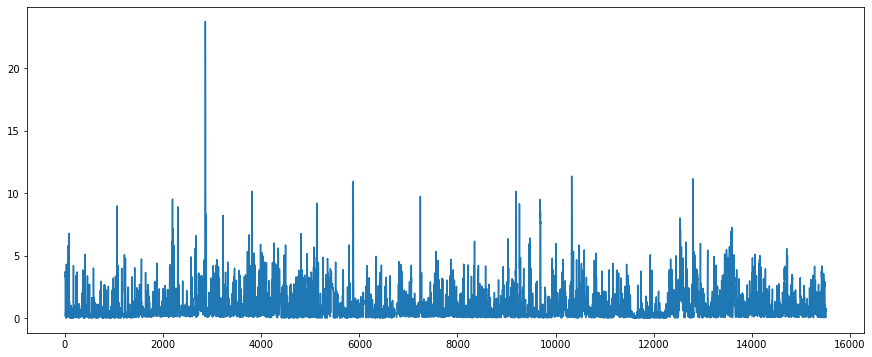

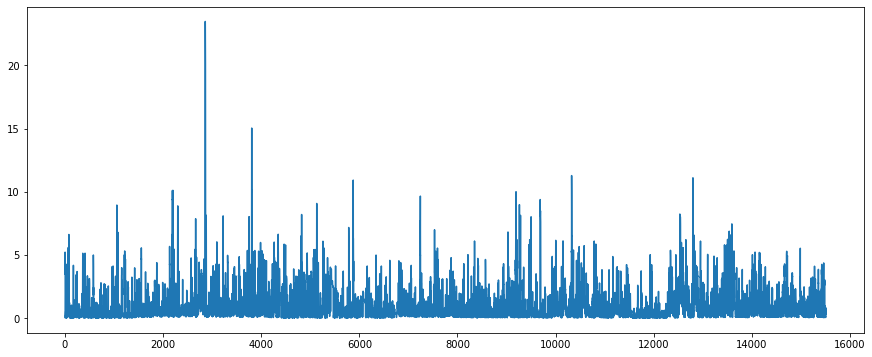

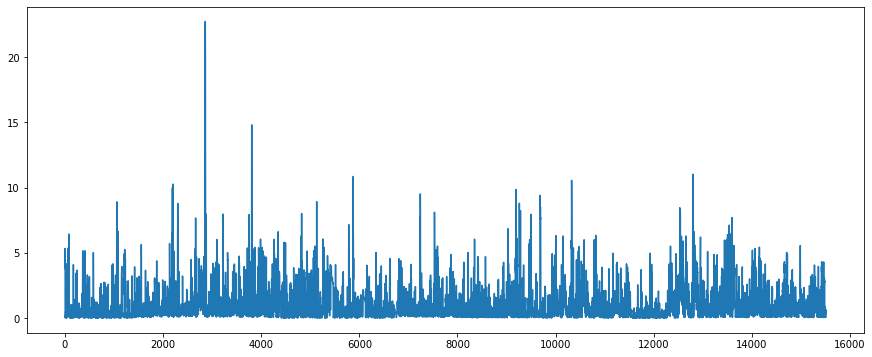

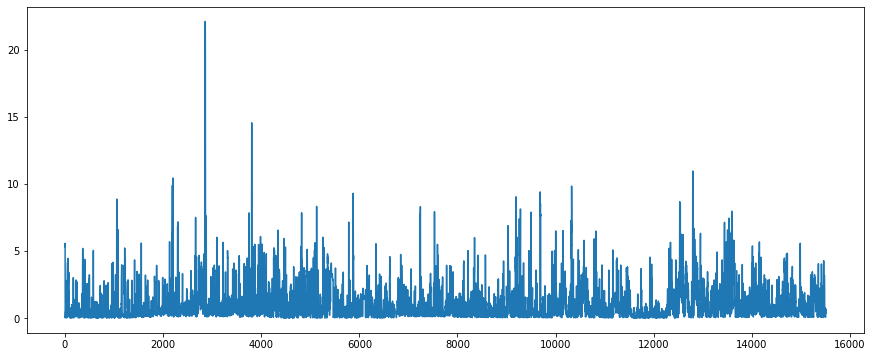

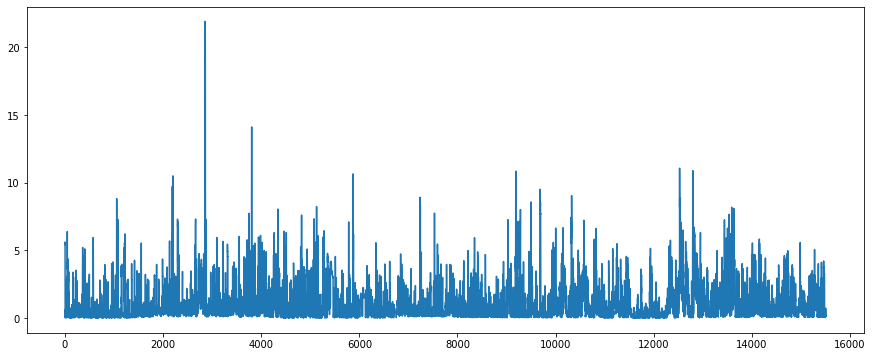

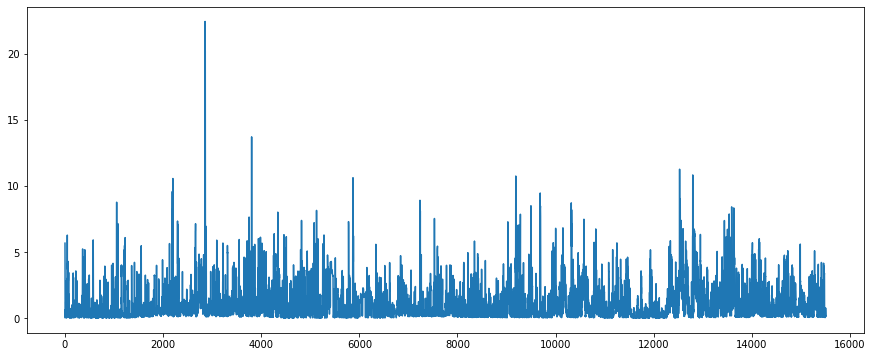

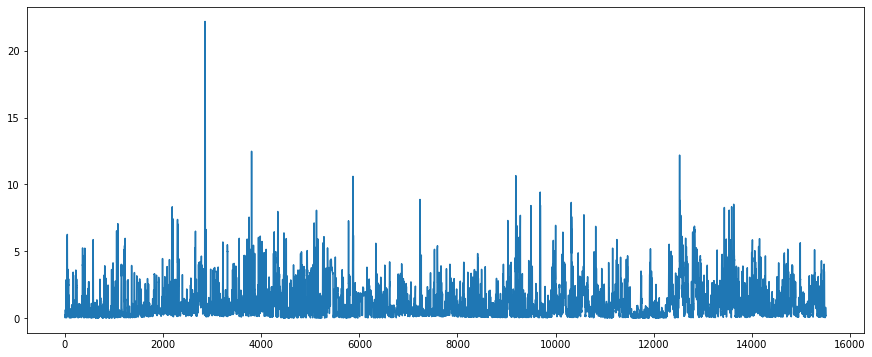

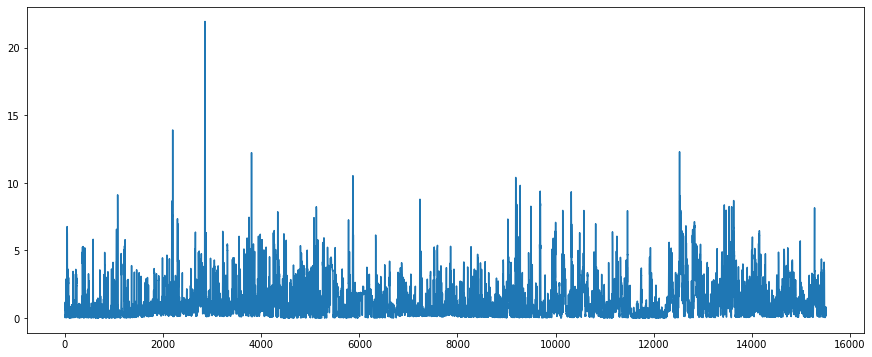

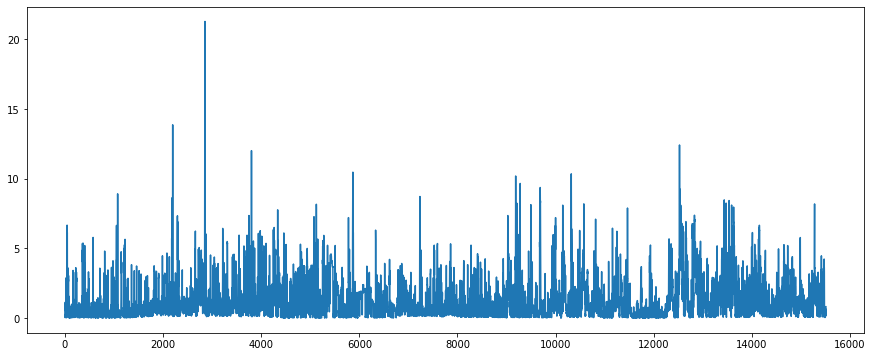

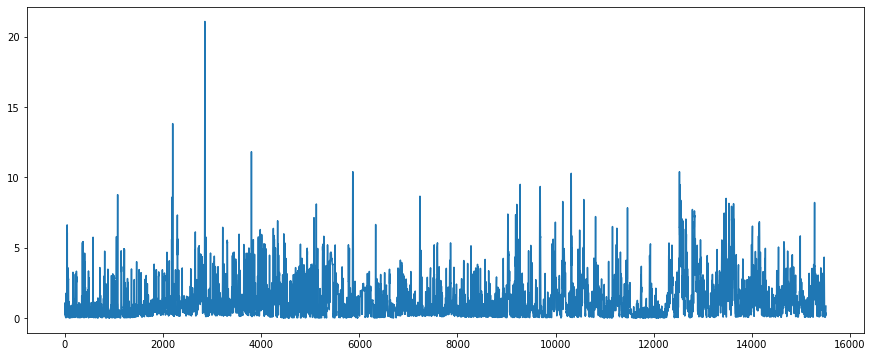

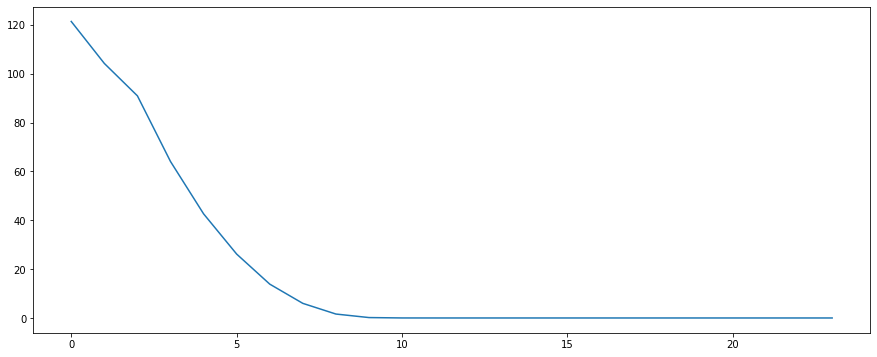

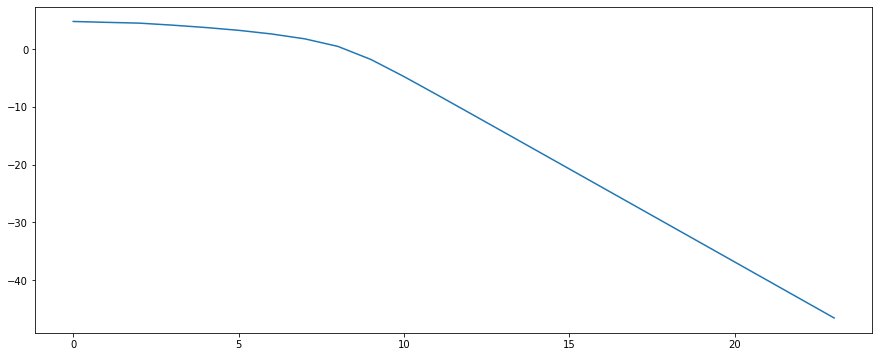

In [20]:
#Future timesteps 

mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    plt.figure(figsize=(15,6))
    #title = "NN Prediction Leaky 100 10 6:"+" "+str(b)
    #plt.title(title)
    #pic_title = title + str(".png")
    plt.plot(mse2)
    #plt.savefig(pic_title)
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 
#print(mse_ROM)

for a in range(pred_number):
    #General
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    #x_test = np.concatenate((y_test, sw_data_test), axis=1)

    #ROM
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_rom = 0 
    for x in range(len(errFullPred)):
        for y in range(len(errFullPred[0])):
            mse_rom += errFullPred[x][y]**2
    mse_ROM[0][a] = mse_rom/(errFullPred.shape[0]*errFullPred.shape[1])
    mse_rom2 = np.zeros(errFullPred.shape[0])
    for i2 in range(len(errFullPred)):
        for j2 in range(len(errFullPred[0])):
            mse_rom2[i2] += errFullPred[i2][j2]**2
        mse_rom2[i2] = mse_rom2[i2]/(errFullPred.shape[1])
    plt.figure(figsize=(15,6))
    plt.plot(mse_rom2)
    
print(mse_ROM) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)

factor_log = np.log(factor)
plt.figure(figsize = (15,6))
plt.plot(factor_log)

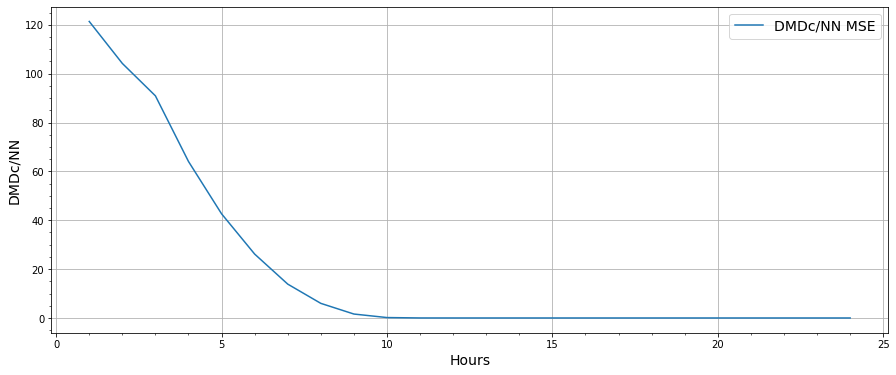

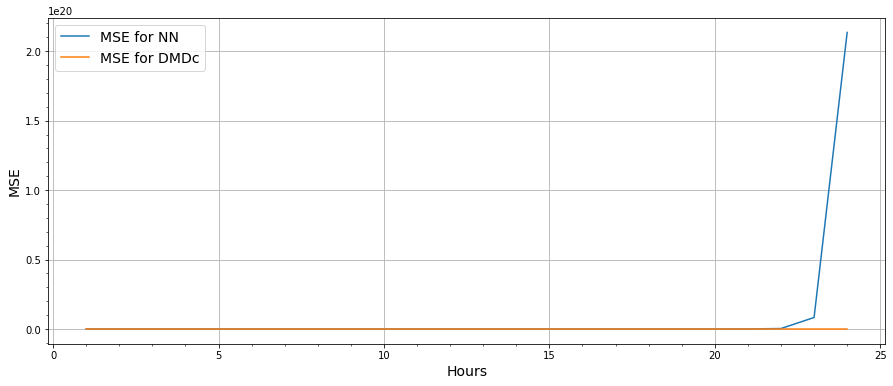

In [21]:
plt.figure(figsize = (15,6))
#plt.title("JB 1999-2010: DMDc/NN MSE for 24 Hours Time Series")
plt.plot(range(1,1+len(factor)),factor, label = "DMDc/NN MSE")
plt.grid()
plt.minorticks_on()
plt.legend(fontsize=14)
plt.xlabel("Hours", fontsize=14)
plt.ylabel("DMDc/NN", fontsize=14)


plt.figure(figsize = (15,6))
#plt.title("JB 1999-2010: Comparison of MSE for 24 Hours Time Series")

plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
#norm_mse.set_xlim(1,len(factor))
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
#ax.grid(which='minor', linestyle=':', linewidth='0.', color='black')
plt.xlabel("Hours",fontsize=14)
plt.ylabel("MSE",fontsize=14)
plt.legend(fontsize=14)

## Compare errors over recurrent timesteps for model
>for pred_number of hrs

In [1]:
#Future timesteps 

mse_NN = np.zeros((1,pred_number))

x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

for b in range(pred_number):
    y_pred = test_model.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    plt.figure(figsize=(15,6))
    #title = "NN Prediction Leaky 100 10 6:"+" "+str(b)
    #plt.title(title)
    #pic_title = title + str(".png")
    plt.plot(mse2)
    #plt.savefig(pic_title)
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)


NameError: name 'np' is not defined